Объявление бибилиотек и физические параметры тележки с маятником 

In [127]:
import numpy as np
import sympy
import scipy
import math
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import tf2ss
import control as ct



M = 0.4
m = 0.2    
l = 0.25   
g = 9.8   
f = 0.0   



Описание системы в форме Коши

In [8]:
def po_koshi(y, t):
    theta, dtheta, x, dx = y
    sin_theta = math.sin(theta)
    cos_theta = math.cos(theta)
    
    denominator = (M + m)*l - m*l*cos_theta**2
    
    ddtheta = ((M + m)*g*sin_theta - m*l*dtheta**2*sin_theta*cos_theta - f*cos_theta) / denominator
    ddx = (m*l**2*dtheta**2*sin_theta + l*f - m*g*l*sin_theta*cos_theta) / denominator
    
    return [dtheta, ddtheta, dx, ddx]

def model(
        theta0, 
        dtheta0, 
        ts=10, nt=0.1, x0 = 0.0, dx0 = 0.0
        ):
 
    initial_conditions = [theta0, dtheta0, x0,dx0]
    t = np.arange(0, ts, nt)
    sol = odeint(po_koshi, initial_conditions, t)
    return sol

Построение фазового портрета с нулевыми условиями по положению и скорости каретки в собственном базисе

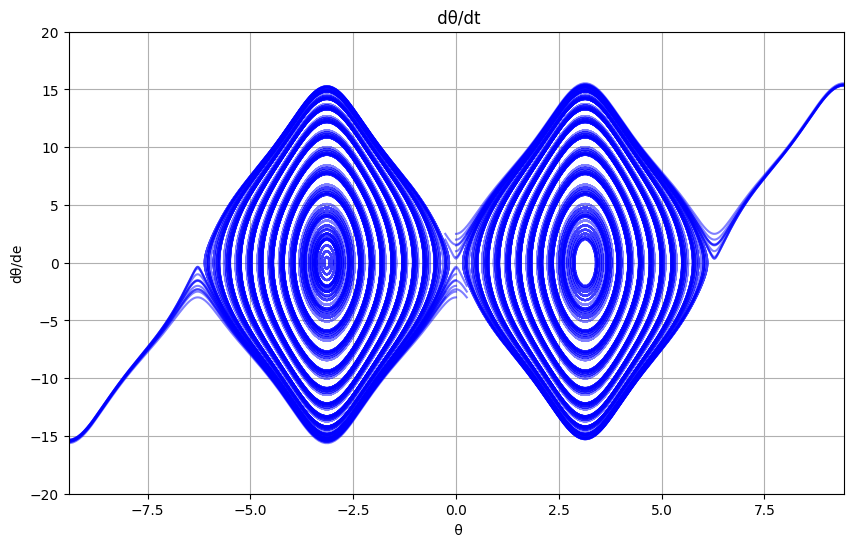

In [9]:
def calcODE(theta0, dtheta0, ts=10, nt=101):
    
    x0 = 0.0   
    dx0 = 0.0  
    
    initial_conditions = [theta0, dtheta0, x0, dx0]
    t = np.linspace(0, ts, nt)  
    sol = odeint(po_koshi, initial_conditions, t)
    return sol

def drawPhasePortrait(deltaTheta=0.5, deltaDtheta=0.5, 
                     startTheta=-np.pi, stopTheta=np.pi, 
                     startDtheta=-5, stopDtheta=5, 
                     ts=10, nt=101,
                     xlim=None, ylim=None):
    plt.figure(figsize=(10, 6))
    
  
    startTheta = np.radians(startTheta)
    stopTheta = np.radians(stopTheta)
    deltaTheta = np.radians(deltaTheta)
    
    for theta0 in np.arange(startTheta, stopTheta, deltaTheta):
        for dtheta0 in np.arange(startDtheta, stopDtheta, deltaDtheta):
            sol = calcODE(theta0, dtheta0, ts, nt)
            plt.plot(sol[:, 0], sol[:, 1], 'b', alpha=0.5)  
    
    plt.xlabel(' θ')
    plt.ylabel('dθ/dе')
    plt.title(' dθ/dt')
    plt.grid()
    
    if xlim: plt.xlim(xlim)
    if ylim: plt.ylim(ylim)
    

    
    plt.show()


drawPhasePortrait(deltaTheta=15, deltaDtheta=0.5, 
                 startTheta=-180, stopTheta=180,
                 startDtheta=-3, stopDtheta=3,
                 ts=5, nt=1000,
                 xlim=[-3*np.pi, 3*np.pi], ylim=[-20, 20])

Линерализация диф уравнений, ФПС

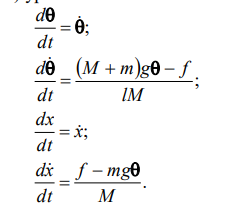

In [10]:
A = np.array([
    [0, 1, 0, 0],
    [(M+m)*g/(l*M), 0, 0, 0],
    [0, 0, 0, 1],
    [-m*g/M, 0, 0, 0]
])

B = np.array([[0], [-1/(l*M)], [0], [1/M]])
C_x = np.array([[0, 0, 1, 0]])
C_theta = np.array([[1, 0, 0, 0]])
D = np.array([[0]])
sys = ct.ss(A, B, C_x, D)

Построение матриц наблюдаемости и управляемости через передачу тета

In [11]:
Q = ct.obsv(A, C_theta)
W = ct.ctrb(A, B)
print("Матрица наблюдаемости:")
print(Q)
print(" ")
print("Матрица управляемости")
print(W)

Матрица наблюдаемости:
[[ 1.   0.   0.   0. ]
 [ 0.   1.   0.   0. ]
 [58.8  0.   0.   0. ]
 [ 0.  58.8  0.   0. ]]
 
Матрица управляемости
[[   0.   -10.     0.  -588. ]
 [ -10.     0.  -588.     0. ]
 [   0.     2.5    0.    49. ]
 [   2.5    0.    49.     0. ]]


Система не наблюдаема

Построение матриц наблюдаемости и управляемости через передачу x

In [12]:
Q = ct.obsv(A, C_x)
W = ct.ctrb(A, B)
print("Матрица наблюдаемости:")
print(Q)
print(" ")
print("Матрица управляемости")
print(W)
print(" ")
print("Ранг матрицы Q: ", np.linalg.matrix_rank(Q))
print("Ранг матрицы W: ", np.linalg.matrix_rank(W))

Матрица наблюдаемости:
[[ 0.   0.   1.   0. ]
 [ 0.   0.   0.   1. ]
 [-4.9  0.   0.   0. ]
 [ 0.  -4.9  0.   0. ]]
 
Матрица управляемости
[[   0.   -10.     0.  -588. ]
 [ -10.     0.  -588.     0. ]
 [   0.     2.5    0.    49. ]
 [   2.5    0.    49.     0. ]]
 
Ранг матрицы Q:  4
Ранг матрицы W:  4


Система и управляема, и наблюдаема

Передаточная функция

In [13]:
G = ct.ss2tf(sys)
print("Передаточная функция G(s):")
G


Передаточная функция G(s):


TransferFunction(array([ 1.74860126e-15,  2.50000000e+00,  4.61149518e-15, -9.80000000e+01]), array([  1. ,   0. , -58.8,   0. ,   0. ]))

Числитель и знаменатель передаточной функции

In [14]:
B_s = np.poly1d(G.num[0][0])
A_s=np.poly1d (G.den[0][0])

print("Числитель передаточной функции G(s):")
print(B_s)
print(" ")
print("\nЗнаменатель передаточной функции G(s):")
print(A_s)

Числитель передаточной функции G(s):
           3       2
1.749e-15 x + 2.5 x + 4.611e-15 x - 98
 

Знаменатель передаточной функции G(s):
   4        2
1 x - 58.8 x


Нахождение корней и полюсов

C:\Users\semen\AppData\Local\Temp\ipykernel_22416\1323583510.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


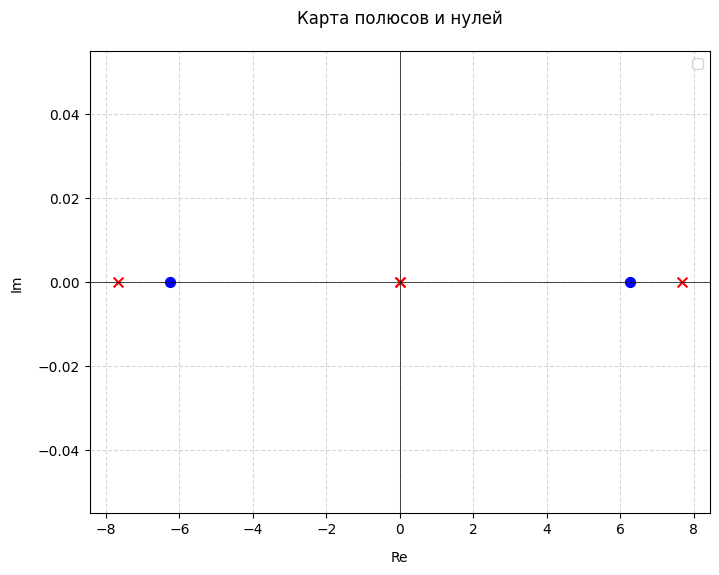

In [15]:
poles = ct.poles(sys)
zeros = ct.zeros(sys)


plt.figure(figsize=(8, 6))
plt.scatter(np.real(poles), np.imag(poles), marker='x', color='r', s=50)
plt.scatter(np.real(zeros), np.imag(zeros), marker='o', color='b', s=50)


plt.axhline(0, color='k', linestyle='-', linewidth=0.5)
plt.axvline(0, color='k', linestyle='-', linewidth=0.5)
plt.grid(True, linestyle='--', alpha=0.5)


plt.title('Карта полюсов и нулей', pad=20)
plt.xlabel('Re', labelpad=10)
plt.ylabel('Im', labelpad=10)
plt.legend()

Система не устойчива

## Компьютерное моделирование линейной системы

Text(0.5, 1.0, 'Модуляция')

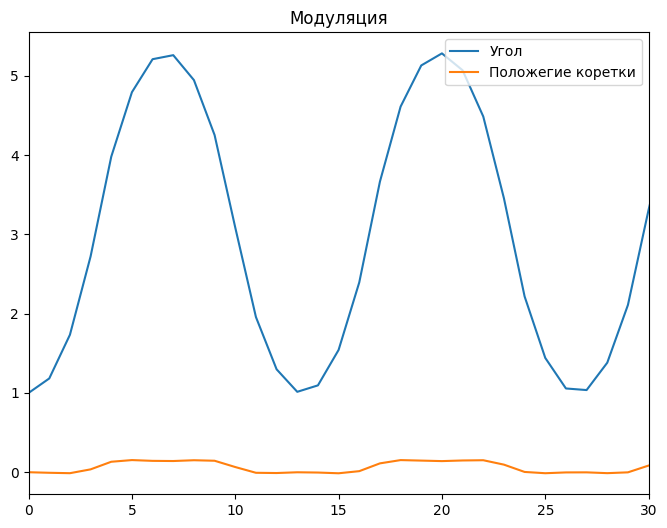

In [16]:
stats = model(1, 0, 100, 0.1)
plt.figure(figsize=(8, 6))
plt.plot(stats[:, 0], label = 'Угол')
plt.plot(stats[:, 2], label = 'Положегие коретки')

plt.xlim(0, 30)

plt.legend(loc = 'upper right')


plt.title('Модуляция')

##### Поведение объекта управления при  начальных условиях (1 0 0 0)

## Синтез регулятора

In [17]:
s = sympy.symbols("s")
W_o = 1/M*(s**2-g/l)/(s**2*(s**2-(M+m)/(l*M)*g))
a_1, a_2, a_3, a_0 = sympy.symbols('a_1, a_2, a_3, a_0')
b_1, b_2, b_0 = sympy.symbols('b_1, b_2, b_0')
W_p = (a_3*s**3+a_2*s**2+a_1*s+a_0) /\
      (s**3+b_2*s**2+b_1*s+b_0)

print("Регулятор")
W_p


Регулятор


(a_0 + a_1*s + a_2*s**2 + a_3*s**3)/(b_0 + b_1*s + b_2*s**2 + s**3)

In [18]:
A_o = 1/M*(s**2-g/l)
B_o = (s**2*(s**2-(M+m)/(l*M)*g))
W_o = A_o/B_o
W_o

A_p = (a_3*s**3+a_2*s**2+a_1*s+a_0) 
B_p = (s**3+b_2*s**2+b_1*s+b_0)
W_p = A_p/B_p
W_p

A_s = B_o*A_p
B_s = A_o*A_p + B_o * B_p
W_s = sympy.together(A_s/B_s)
print("Эквивалентная передаточная функция с обратной связью")
W_s

Эквивалентная передаточная функция с обратной связью


s**2*(s**2 - 58.8)*(a_0 + a_1*s + a_2*s**2 + a_3*s**3)/(s**2*(s**2 - 58.8)*(b_0 + b_1*s + b_2*s**2 + s**3) + (2.5*s**2 - 98.0)*(a_0 + a_1*s + a_2*s**2 + a_3*s**3))

In [19]:
eq = sympy.Eq(B_s,(s+1)**7)
eq

Eq(s**2*(s**2 - 58.8)*(b_0 + b_1*s + b_2*s**2 + s**3) + (2.5*s**2 - 98.0)*(a_0 + a_1*s + a_2*s**2 + a_3*s**3), (s + 1)**7)

In [20]:
solv = sympy.solve(eq,[a_1,a_2,a_3,a_0,b_1,b_2,b_0])
solv

{a_0: -0.0102040816326531,
 a_1: -0.0714285714285714,
 a_2: 536.349092044981,
 a_3: 96.4779300291545,
 b_0: -894.272730112453,
 b_1: -161.394825072886,
 b_2: 7.00000000000000}

## Моделирование нелинейной системы

#### Матрица параметров

In [21]:
W_p_num = np.array(sympy.Poly(A_p.subs(solv), s).all_coeffs()).astype(np.float32)
W_p_den = np.array(sympy.Poly(B_p.subs(solv), s).all_coeffs()).astype(np.float32)

In [22]:
A_, B_, C_, D_ = tf2ss(W_p_num, W_p_den)
reg = ct.ss(A_, B_, C_, D_)
reg

StateSpace(array([[ -7.        , 161.39482117, 894.27270508],
       [  1.        ,   0.        ,   0.        ],
       [  0.        ,   1.        ,   0.        ]]), array([[1.],
       [0.],
       [0.]]), array([[ -138.99639893, 15570.96679688, 86277.5703125 ]]), array([[96.47792816]]))

In [23]:
sys

StateSpace(array([[ 0. ,  1. ,  0. ,  0. ],
       [58.8,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  1. ],
       [-4.9,  0. ,  0. ,  0. ]]), array([[  0. ],
       [-10. ],
       [  0. ],
       [  2.5]]), array([[0., 0., 1., 0.]]), array([[0.]]))

In [24]:
sys_reg = ct.feedback(sys, reg)
sys_reg

StateSpace(array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.88000000e+01,  0.00000000e+00,  9.64779282e+02,
         0.00000000e+00, -1.38996399e+03,  1.55709668e+05,
         8.62775703e+05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-4.90000000e+00,  0.00000000e+00, -2.41194820e+02,
         0.00000000e+00,  3.47490997e+02, -3.89274170e+04,
        -2.15693926e+05],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00, -7.00000000e+00,  1.61394821e+02,
         8.94272705e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
       

In [25]:
def regul_sys(y, t):
    dy = sys_reg.A@y+sys_reg.B.reshape(-1)*f
    
    return dy

In [26]:
def model_reg(
        func, 
        theta0, 
        dtheta0, 
        ts=10, nt=0.1, x0 = 0.0, dx0 = 0.0
        ):
    initial_conditions = np.array([theta0, dtheta0, x0, dx0, 0, 0, 0])
    t = np.arange(0, ts, nt)
    sol = odeint(func, initial_conditions, t)
    return sol

stats = model_reg(regul_sys, 0.08, 0, 100, 0.1)

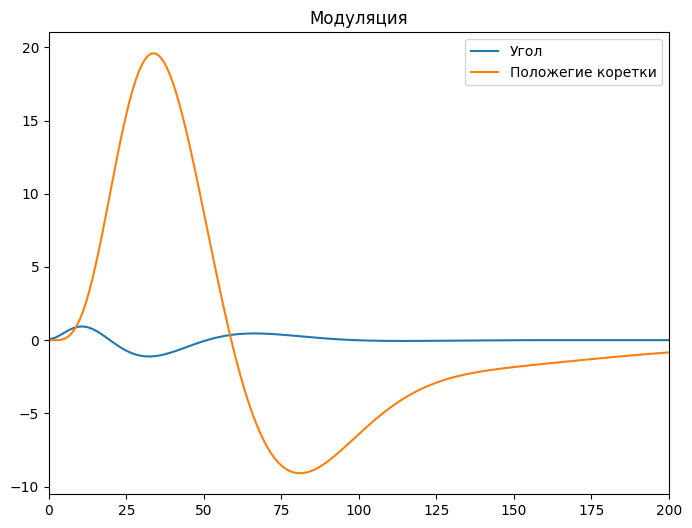

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(stats[:, 0], label = 'Угол')
plt.plot(stats[:, 2], label = 'Положегие коретки')



plt.legend(loc = 'upper right')
plt.xlim(0,200)
plt.title('Модуляция')
plt.show()

## Синтез системы стабилизации перевернутого маятника на каретке методами пространства состояний


### Линерализация модели

In [57]:
print("A =", A)
print("B =", B)
print("C =", C_x)
print("D =", D)

A = [[ 0.   1.   0.   0. ]
 [58.8  0.   0.   0. ]
 [ 0.   0.   0.   1. ]
 [-4.9  0.   0.   0. ]]
B = [[  0. ]
 [-10. ]
 [  0. ]
 [  2.5]]
C = [[0 0 1 0]]
D = [[0]]


#### Синтез регулятора

In [95]:
p = np.array ([-1, -2, -4, -7])
W = ct.ctrb(A, B)
print("Ранг матрицы управляемости =", np.linalg.matrix_rank(W))

Ранг матрицы управляемости = 4


In [59]:
K = ct.place(A, B, p)
print("Матрица обратной связи K =", K)

Матрица обратной связи K = [[-12.32285714  -1.67040816  -0.57142857  -1.08163265]]


In [60]:
A_closed = A - B @ K
print("Матрица замкнутой системы A_closed =", )
A_closed

Матрица замкнутой системы A_closed =


array([[  0.        ,   1.        ,   0.        ,   0.        ],
       [-64.42857143, -16.70408163,  -5.71428571, -10.81632653],
       [  0.        ,   0.        ,   0.        ,   1.        ],
       [ 25.90714286,   4.17602041,   1.42857143,   2.70408163]])

In [61]:
p_closed = np.linalg.eigvals(A_closed)
print("Полюса замкнутой системы =", ) 
p_closed

Полюса замкнутой системы =


array([-7., -4., -2., -1.])

#### Синтез наблюдатедя

In [96]:
p_L = 5 * p

In [97]:
Q = ct.obsv(A, C_x)
print("Ранг матрицы наблюдаемости:", np.linalg.matrix_rank(Q))

Ранг матрицы наблюдаемости: 4


Система наблюдаема

In [126]:
L = ct.place(A.T, C_x.T, p_L).T
print("Матрица наблюдателя L:\n", L)

Матрица наблюдателя L:
 [[ -3544.08163265]
 [-26748.45714286]
 [    70.        ]
 [  1633.8       ]]


### Динамический регулятор

In [99]:
def dynamic_reg(A, B, C, K, L):

    
    Ar = A - B @ K - L @ C
    Br = L
    Cr = -K
    Dr = np.zeros((K.shape[0], C.shape[0]))
    
    return Ar, Br, Cr, Dr

In [148]:

Ar, Br, Cr, Dr = dynamic_reg(A, B, C_x, K, L)
regulator = ct.ss(Ar, Br, Cr, Dr)

print("Матрицы динамического регулятора:")
print("Ar =\n", Ar)
print("Br =\n", Br)
print("Cr =\n", Cr)
print("Dr =\n", Dr)


Матрицы динамического регулятора:
Ar =
 [[ 0.00000000e+00  1.00000000e+00  3.54408163e+03  0.00000000e+00]
 [-6.44285714e+01 -1.67040816e+01  2.67427429e+04 -1.08163265e+01]
 [ 0.00000000e+00  0.00000000e+00 -7.00000000e+01  1.00000000e+00]
 [ 2.59071429e+01  4.17602041e+00 -1.63237143e+03  2.70408163e+00]]
Br =
 [[ -3544.08163265]
 [-26748.45714286]
 [    70.        ]
 [  1633.8       ]]
Cr =
 [[12.32285714  1.67040816  0.57142857  1.08163265]]
Dr =
 [[0.]]


### Проверка устойчивости регулятора

#### Передаточная функция

In [101]:
regulator_tf = ct.ss2tf(regulator)
print("Передаточная функция регулятора:")
regulator_tf

Передаточная функция регулятора:


TransferFunction(array([ -86546.88139941, -657999.88146888,   45428.57142885,
         20000.00000056]), array([ 1.00000000e+00,  8.40000000e+01,  2.67680000e+03, -1.71612003e+05,
       -1.16040286e+06]))

#### Корни

In [110]:
regulator_poles = np.linalg.eigvals(Ar)

print("Собственные значения матрицы регулятора Ar:")
regulator_poles

Собственные значения матрицы регулятора Ar:


array([-55.00884284+52.10899229j, -55.00884284-52.10899229j,
        32.2791385  +0.j        ,  -6.26145283 +0.j        ])

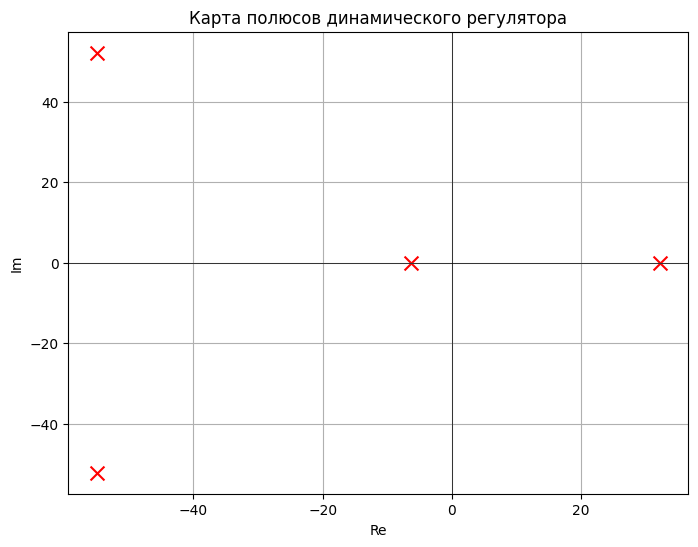

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(np.real(regulator_poles), np.imag(regulator_poles), marker='x', color='r', s=100)
plt.axhline(0, color='k', linestyle='-', linewidth=0.5)
plt.axvline(0, color='k', linestyle='-', linewidth=0.5)
plt.title('Карта полюсов динамического регулятора')
plt.xlabel('Re')
plt.ylabel('Im')
plt.grid(True)
plt.show()

### Анализ системы с динамическим регулятором

#### Система с обратной связью с регулятором

In [ ]:
closed_sys = ct.feedback(ct.ss(A, B, C_x, D), regulator_tf, sign=1)
poles = ct.poles(closed_sys)
poles

array([-35.        +0.j, -20.        +0.j, -10.        +0.j,
        -7.        +0.j,  -4.99999999+0.j,  -4.00000001+0.j,
        -2.        +0.j,  -1.        +0.j])

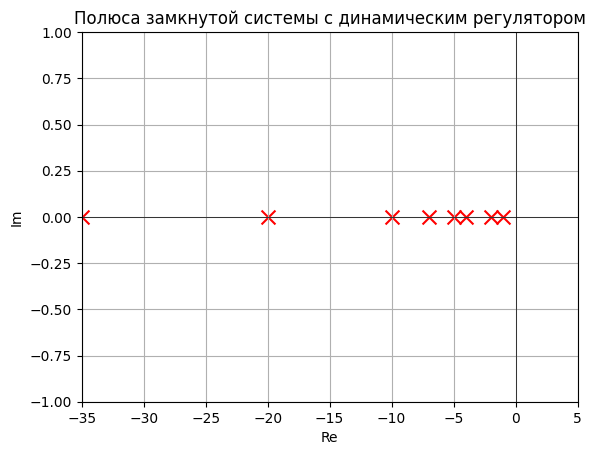

In [141]:

plt.scatter(np.real(poles), np.imag(poles), 
            marker='x', color='r', s=100)
plt.axhline(0, color='k', linestyle='-', linewidth=0.5)
plt.axvline(0, color='k', linestyle='-', linewidth=0.5)
plt.title('Полюса замкнутой системы с динамическим регулятором')
plt.xlabel('Re')
plt.ylabel('Im')
plt.xlim(-35,5)
plt.ylim(-1,1)
plt.grid(True)
plt.show()

In [150]:
regulator = ct.ss(Ar, Br, Cr, Dr)
plant = ct.ss(A, B, C_x, D)
def closed_loop_system(y, t):

    theta, dtheta, x, dx = y[:4]
    theta_est, dtheta_est, x_est, dx_est = y[4:8]
    
    y_meas = x
    
    u = -K @ np.array([theta_est, dtheta_est, x_est, dx_est])
    
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    denominator = (M + m)*l - m*l*cos_theta**2
    ddtheta = ((M + m)*g*sin_theta - m*l*dtheta**2*sin_theta*cos_theta - u*cos_theta) / denominator
    ddx = (m*l**2*dtheta**2*sin_theta + l*u - m*g*l*sin_theta*cos_theta) / denominator
    

    dz = A @ np.array([theta_est, dtheta_est, x_est, dx_est]) + B.flatten()*u + L.flatten()*(y_meas - x_est)
    
    return [
        dtheta, ddtheta[0], dx, ddx[0],  
        dz[0], dz[1], dz[2], dz[3]       
    ]

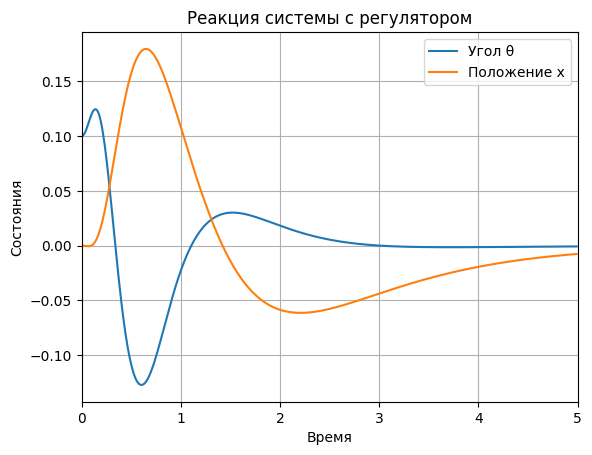

In [153]:
def simulate_simple(theta0=0.03, ts=5, nt=0.01):
    x0 = np.array([theta0, 0, 0, 0])  
    z0 = np.zeros(4)                  
    y0 = np.concatenate([x0, z0])
    
    t = np.arange(0, ts, nt)
    sol = odeint(closed_loop_system, y0, t)
    
 
    plt.plot(t, sol[:, 0], label='Угол θ')
    plt.plot(t, sol[:, 2], label='Положение x')
    plt.xlim(0,5)
    plt.xlabel('Время')
    plt.ylabel('Состояния')
    plt.title('Реакция системы с регулятором')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return t, sol

t, results = simulate_simple(theta0=0.1, ts=5)

In [154]:
closed_sys

StateSpace(array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 5.88000000e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  8.65468814e+05,  6.57999881e+06,
        -4.54285714e+05, -2.00000000e+05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-4.90000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -2.16367203e+05, -1.64499970e+06,
         1.13571429e+05,  5.00000000e+04],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00, -8.40000000e+01, -2.67680000e+03,
         1.71612003e+05,  1.16040286e+06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00